In [1]:
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import Aggregate_PAZ_Data as agg
import scikit_posthocs as ph
datafile = "Eam/Presynaptic-Intensity_CoV.csv"
savepath = "late/2D_Analysis/"


In [2]:
if not os.path.isdir(savepath):
    os.mkdir(savepath)
data = pd.read_csv(datafile)
chans=["NWK", "DYN", "BRP"]
for c in [1,2,3]:
    data=data.rename(columns={f"Ch-{c}_Mean":f"{chans[c-1]}_Mean", f"Ch-{c}_CoV":f"{chans[c-1]}_CoV"})

In [3]:
data["geno"] = data.loc[:, 'File'].str.slice(6, 10)
data["larva"] = data.loc[:, 'File'].str.slice(11, 14)

(0.0, 7972.3169055)

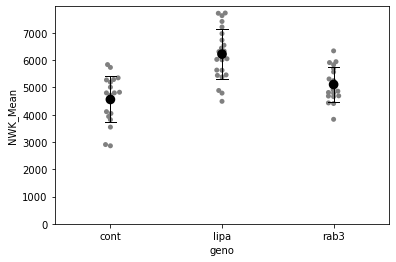

In [4]:
chan = "NWK"
sp=sns.swarmplot(data=data, x="geno", y=f"{chan}_Mean", palette=['0.5'], zorder=0)
sns.pointplot(data=data, x="geno", y=f"{chan}_Mean", ci='sd', palette=['k'], 
    scale=1.1, join=False, capsize=.1, errwidth=1, ax=sp)
min, max = sp.get_ylim()
sp.set_ylim(0, max)

(0.0, 6166.1409125)

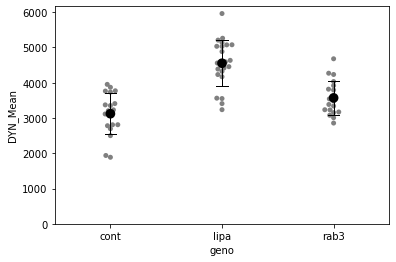

In [5]:
chan = "DYN"
sp=sns.swarmplot(data=data, x="geno", y=f"{chan}_Mean", palette=['0.5'], zorder=0)
sns.pointplot(data=data, x="geno", y=f"{chan}_Mean", ci='sd', palette=['k'], 
    scale=1.1, join=False, capsize=.1, errwidth=1, ax=sp)
min, max = sp.get_ylim()
sp.set_ylim(0, max)

(0.0, 1386.9449665000002)

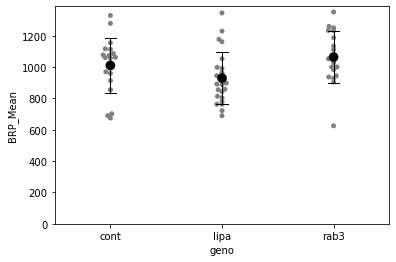

In [6]:
chan = "BRP"
sp=sns.swarmplot(data=data, x="geno", y=f"{chan}_Mean", palette=['0.5'], zorder=0)
sns.pointplot(data=data, x="geno", y=f"{chan}_Mean", ci='sd', palette=['k'], 
    scale=1.1, join=False, capsize=.1, errwidth=1, ax=sp)
min, max = sp.get_ylim()
sp.set_ylim(0, max)

In [7]:
for chan in chans:
    sp=sns.swarmplot(data=data, x="geno", y=f"{chan}_Mean", palette=['0.5'], zorder=0)
    sns.pointplot(data=data, x="geno", y=f"{chan}_Mean", ci='sd', palette=['k'], 
        scale=1.1, join=False, capsize=.1, errwidth=1, ax=sp)
    min, max = sp.get_ylim()
    sp.set_ylim(0, max)
    plt.savefig(os.path.join(savepath, f"{chan}_Mean.svg"))
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [8]:
for chan in chans:
    sp=sns.swarmplot(data=data, x="geno", y=f"{chan}_CoV", palette=['0.5'], zorder=0)
    sns.pointplot(data=data, x="geno", y=f"{chan}_CoV", ci='sd', palette=['k'], 
        scale=1.1, join=False, capsize=.1, errwidth=1, ax=sp)
    min, max = sp.get_ylim()
    sp.set_ylim(0, max)
    plt.savefig(os.path.join(savepath, f"{chan}_CoV.svg"))
    plt.clf()

<Figure size 432x288 with 0 Axes>

## Stats

In [34]:
from scipy.stats import norm, kstest, kruskal, f_oneway as anova, ttest_ind as ttest, mannwhitneyu as mwu 

In [10]:
kstest(data.loc[data["NWK_Mean"].notna(), "NWK_Mean"], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [11]:
data.loc[data["NWK_Mean"].notna(), "NWK_Mean"]

0     4823.98501
1     5273.28054
2     5288.99443
3     3935.16062
4     4046.05419
         ...    
56    5694.37635
57    4915.47609
58    4790.21604
59    4432.13222
60    5944.27906
Name: NWK_Mean, Length: 61, dtype: float64

In [14]:
tests=data.set_index(["File", "geno"])

In [15]:
tests=tests.unstack("geno")

In [16]:
tests=tests.reset_index().drop(["File", "larva"], axis=1)

c:\Users\sdels\miniconda3\envs\defects\envs\segment_paz\envs\paz_analysis\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [17]:
ks = [kstest(tests.loc[tests[col].notna(), col], 'norm') for col in tests]

In [41]:
tests["NWK_Mean"].mean()

geno
cont    4559.007399
lipa    6220.880755
rab3    5108.236916
dtype: float64

In [42]:
normN = norm.rvs(loc=tests["NWK_Mean"].cont.mean(), scale=tests["NWK_Mean"].cont.std(), size=20)
normN

array([4914.15311709, 3640.66405043, 4563.42155351, 4399.3235302 ,
       3515.47319396, 4112.43083707, 3041.5544516 , 5834.34484291,
       4225.11090619, 5435.58672332, 6073.76024501, 4673.93607556,
       4816.42909171, 2997.44818529, 3658.63408052, 4125.17602126,
       5842.26949739, 4979.26282395, 3807.50477046, 6119.42291567])

In [43]:
kstest(tests.loc[tests["NWK_Mean"].cont.notna(), "NWK_Mean"].cont, normN)

KstestResult(statistic=0.18157894736842106, pvalue=0.8247622484020414)

In [60]:
results = {}
for measure in tests.columns.get_level_values(0).unique():
    testDists = [norm.rvs(loc=tests[measure][col].mean(), scale=tests[measure][col].std(), size=20) for col in tests[measure]]
    ks = [kstest(tests.loc[tests[measure][col].notna(), measure][col], dist) for col, dist in zip(tests[measure], testDists)]
    kpass = True if np.min(np.array(ks)[:,1])>0.05 else False
    posthoc=np.nan
    if kpass:
        ttype='anova'
        test = anova(*[tests.loc[tests[measure][col].notna(), measure][col] for col in tests[measure]])
        if test[1] < 0.05:
            phdata = tests[measure].melt()
            phdata = phdata.loc[phdata.value>0]
            posthoc = ph.posthoc_ttest(phdata, group_col='geno', val_col='value', p_adjust='sidak')
    else:   
        ttype='kruskal'
        test = kruskal(*[tests[measure][col] for col in tests[measure]], nan_policy='omit') 
        if test[1] < 0.05:
            # Do posthoc dunns if model is significant
            phdata = tests[measure].melt()
            phdata = phdata.loc[phdata.value>0]
            posthoc = ph.posthoc_dunn(phdata, group_col='geno', val_col='value', p_adjust='sidak')
    
    results[measure] = {'test':ttype, 'p':test[1], 'post':posthoc}

In [61]:
for meas in results.keys():
    if type(results[meas]["post"]) == type(pd.DataFrame()):
        results[meas]["post"].to_csv(os.path.join(savepath, f"{meas}_Posthoc.csv"))

In [62]:
resultsDf = pd.DataFrame(results).drop("post", axis=0)
resultsDf

,PreArea,NWK_Mean,NWK_CoV,DYN_Mean,DYN_CoV,BRP_Mean,BRP_CoV
test,anova,anova,anova,anova,anova,anova,anova
p,0.14777,0.0,0.086663,0.0,0.089263,0.047295,0.0


In [63]:
resultsDf.to_csv(os.path.join(savepath, "StatSummary.csv"))